In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function filtering_model()
    model = Model()
    
    x_prior_mean = datavar(model, :x_prior_mean, PointMass{Float64})
    x_prior_var  = datavar(model, :x_prior_var, PointMass{Float64})
    
    _, x_prior = make_node(model, NormalMeanVariance, AutoVar(:x_prior), x_prior_mean, x_prior_var)
    
    c = constvar(model, :c, 1.0)
    
    _, x = make_node(model, +, AutoVar(:x), x_prior, c)
    
    noise_mean = constvar(model, :noise_mean, 0.0)
    noise_var  = constvar(model, :noise_var, 200.0)
    
    _, noise = make_node(model, NormalMeanVariance, AutoVar(:noise), noise_mean, noise_var)
    
    y = datavar(model, :y, PointMass{Float64})
    
    _ = make_node(model, +, y, x, noise)
    
    activate!(model)
    
    return x_prior_mean, x_prior_var, x, y
end

function filtering(data)
    N = length(data)
    
    x_prior_mean, x_prior_var, x, y = filtering_model()
    
    marginals = Vector{NormalMeanVariance{Float64}}()
    
    subscription = subscribe!(getmarginal(x), (t) -> begin
        update!(x_prior_mean, mean(t))
        update!(x_prior_var, var(t))

        push!(marginals, getdata(t))
    end)
    
    update!(x_prior_mean, 0.0)
    update!(x_prior_var, 100000.0)
    
    for d in data
        update!(y, d)
    end
    
    unsubscribe!(subscription)
    
    return marginals
end

filtering (generic function with 1 method)

In [3]:
N = 600
data = collect(1:N) + sqrt(200.0) * randn(N);

In [4]:
@time filtering(data); # Initial compilation

  3.866734 seconds (8.85 M allocations: 471.880 MiB, 7.57% gc time)


In [5]:
@time filtering(data); # Subsequent runs

  0.001608 seconds (32.25 k allocations: 1.527 MiB)


In [6]:
@btime filtering($data); # Performance benchmark

  1.264 ms (32252 allocations: 1.53 MiB)


In [7]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


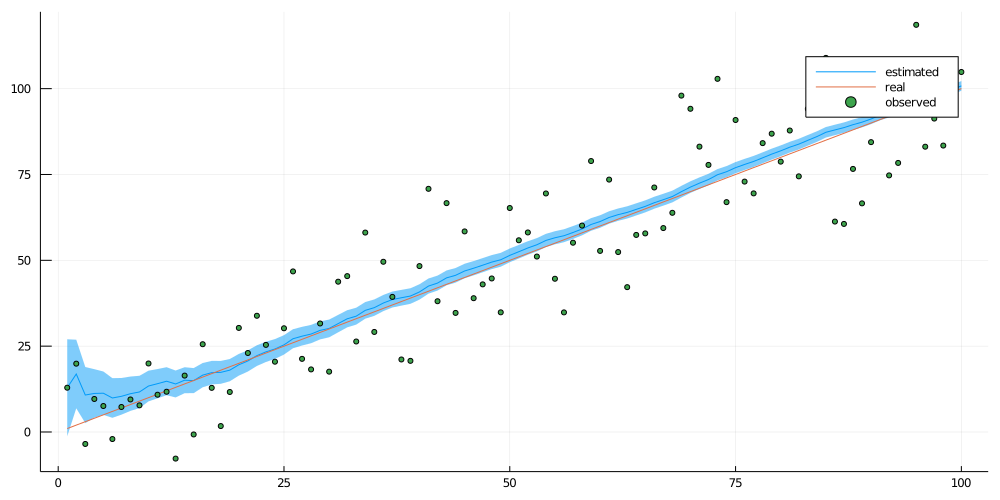

In [8]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = filtering(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))

In [9]:
filtering(data)

600-element Array{NormalMeanVariance{Float64},1}:
 NormalMeanVariance{Float64}(μ=11.940400635750397, v=199.6007984031936)
 NormalMeanVariance{Float64}(μ=15.223184141008032, v=99.9000999000999)
 NormalMeanVariance{Float64}(μ=16.360836168764283, v=66.62225183211193)
 NormalMeanVariance{Float64}(μ=12.522927649618287, v=49.97501249375312)
 NormalMeanVariance{Float64}(μ=16.67325900677579, v=39.98400639744102)
 NormalMeanVariance{Float64}(μ=13.16397305215445, v=33.322225924691764)
 NormalMeanVariance{Float64}(μ=13.991372310287295, v=28.563267637817763)
 NormalMeanVariance{Float64}(μ=13.59894269222709, v=24.99375156210947)
 NormalMeanVariance{Float64}(μ=15.10802263854737, v=22.21728504776716)
 NormalMeanVariance{Float64}(μ=18.53871012055501, v=19.99600079984003)
 NormalMeanVariance{Float64}(μ=21.0508193772705, v=18.17851299763679)
 NormalMeanVariance{Float64}(μ=20.211948467074727, v=16.6638893517747)
 NormalMeanVariance{Float64}(μ=21.079470088338415, v=15.382248884786952)
 ⋮
 NormalMeanVarian